<div class="alert alert-block alert-warning">
<b>Costs:</b> This QPU simulation costs 450.00 dollars.
</div>

<div class="alert alert-block alert-success">
<b>This simulation runs a circuit with a varying number of gates for the purpose of detecting depolarization error. </b>
<div>Obs. 1: The data is saved in external files so that it can be worked on without incurring new costs.</div>
<div>Obs. 2: For new simulation parameters, save in a file with a different name.</div>
</div>

# Instructions if you are running outside AWS cloud

1. Install aws-cli:

`sudo apt install aws-cli`

2. Setup aws credentials:

`aws configure --profile "default"`

3. Create virtual environment 

`python -m venv /path/to/new/virtual/environment`

4. Activate virtual environment

`source /path/to/new/virtual/environment/bin/activate`

In [ ]:
# Install this modules on your virtual environment
!pip install amazon-braket-sdk
!pip install boto3

In [19]:
from boto3 import Session
from braket.aws import AwsSession

# Start Boto3 Session with your credentials profile
boto_session = Session(profile_name='default')

# Initialize Braket session with Boto3 Session credentials
aws_session = AwsSession(boto_session=boto_session)

# Defining the function to save results to json file and read results from file

In [8]:
import json

def save_to_file(data, file_name):
    with open(file_name+".json", "w") as file:
        json.dump(data, file, indent=4)

def read_from_file(file_name):
    with open(file_name+".json", 'r') as file:
        data = json.load(file)
    return data

# Importing modules

In [9]:
from braket.tracking import Tracker
t = Tracker().start()

In [10]:
# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit
from braket.circuits import Observable
from braket.devices import LocalSimulator

import math

In [11]:
from braket.aws import AwsDevice, AwsQuantumTask
from braket.devices import Devices

from braket.error_mitigation import Debias

# Defining the Parameters of the Simulation

In [12]:
# Define parameters set
parameters_setup = dict(n_qubits=1, n_shots=2500, max_deph=100, step=50, isVerbose=True)
parameters_execution = dict(n_qubits=1, n_shots=2500, max_deph=600, step=100, isVerbose=True)

parameters = parameters_execution

# Defining the Circuit of Interest

In [13]:
# function to build the circuit of interest
def build_circuit_of_interest(n_qubits, deph):
    """
    function to return a circuit
    input: number of qubits and deph of the circuit
    """

    # instantiate circuit object
    circuit = Circuit()

    # add Hadamard gate on first qubit
    for i in range(0,deph):
        # circuit.h(0)
        if (i % 2 == 0):
            circuit.ry(0, math.pi/5)
        # circuit.cnot(0,3)
        else:
            circuit.rz(0, math.pi/2)

    return circuit

# Seting up Quantum Task

In [14]:
def run_task(device, parameters=parameters_setup, isQuantum=False):

    dados = []
    for deph in range(1, parameters['max_deph'], parameters['step']):

        # Build circuit
        circuit = build_circuit_of_interest(parameters['n_qubits'], parameters['max_deph'])

        # Set observables
        tensor_product = Observable.Z()
        circuit.expectation(observable = tensor_product, target=range(0,parameters['n_qubits']))

        # Run circuit
        if not isQuantum:
            task = device.run(circuit, shots=parameters['n_shots'])
        else:
            task = device.run(circuit, shots=parameters['n_shots'], device_parameters={"errorMitigation": Debias()})

        # Gather aplicable data
        if (not isQuantum):
            dados.append((deph, task.result().values[0]))
            if parameters['isVerbose']:
                print(f"Expectation value: {task.result().values[0]}")
                print(f"Amostra: {task.result().measurement_counts}")
        else:
            dados.append((deph, task.id))
            if parameters['isVerbose']:
                print(f"Task Id: {task.id}")

    return dados

# 1. Running Quantum Task on Simulator

In [15]:
# set up device: Local Simulator
simulator = LocalSimulator()

In [16]:
resultset_1 = run_task(simulator, parameters)

Expectation value: 0.652
Amostra: Counter({'0': 2065, '1': 435})
Expectation value: 0.696
Amostra: Counter({'0': 2120, '1': 380})
Expectation value: 0.6704
Amostra: Counter({'0': 2088, '1': 412})
Expectation value: 0.712
Amostra: Counter({'0': 2140, '1': 360})
Expectation value: 0.648
Amostra: Counter({'0': 2060, '1': 440})
Expectation value: 0.6872
Amostra: Counter({'0': 2109, '1': 391})


### Saving Resultset to File

In [17]:
save_to_file(resultset_1, "resultset_1")

# 2. Running task on QPU

In [18]:
# set up device: Aria 2
aria2 = AwsDevice(Devices.IonQ.Aria2, aws_session=aws_session)

In [362]:
task_id_list = run_task(aria2, parameters, isQuantum=True)

Task Id: arn:aws:braket:us-east-1:709381776175:quantum-task/31040d31-ad98-4ed5-84c4-5a6d72faa46e
Task Id: arn:aws:braket:us-east-1:709381776175:quantum-task/e627ad83-9f09-4e4d-8491-fae17f023bcc
Task Id: arn:aws:braket:us-east-1:709381776175:quantum-task/82097427-8527-485f-b26d-904386a56000
Task Id: arn:aws:braket:us-east-1:709381776175:quantum-task/76ac501b-fc2b-4657-b779-6c041bc33065
Task Id: arn:aws:braket:us-east-1:709381776175:quantum-task/85d54d60-6bd3-4b06-9be0-b7ef77562265
Task Id: arn:aws:braket:us-east-1:709381776175:quantum-task/914fbd1e-9fae-4a73-83b3-5b9b4cc331bb


<p>ValidationException: An error occurred (ValidationException) when calling the CreateQuantumTask operation: Number of 1qubit gates should be <=950.0, but 30000 specified and number of 2qubit gates should be <=650.0, but 10000 specified for the device arn:aws:braket:us-east-1::device/qpu/ionq/Aria-2</p>

# Check if the quantum task is completed and get results

In [80]:
resultset_2 = []
for task_id in task_id_list:
    resultset_2.append((task_id[0],getData(task_id[1])))

Status of (reconstructed) quantum task: COMPLETED
Measurement counts: {'0': 2101, '1': 399}
Expected value: 0.6808
Status of (reconstructed) quantum task: COMPLETED
Measurement counts: {'0': 2024, '1': 476}
Expected value: 0.6192
Status of (reconstructed) quantum task: COMPLETED
Measurement counts: {'0': 2080, '1': 420}
Expected value: 0.664
Status of (reconstructed) quantum task: COMPLETED
Measurement counts: {'0': 2082, '1': 418}
Expected value: 0.6656
Status of (reconstructed) quantum task: COMPLETED
Measurement counts: {'0': 2079, '1': 421}
Expected value: 0.6632
Status of (reconstructed) quantum task: COMPLETED
Measurement counts: {'0': 2043, '1': 457}
Expected value: 0.6344


### Save Resultset to File

In [82]:
save_to_file(resultset_2, "resultset_2")

In [16]:
def getData(aria1_task_id):
    # recover quantum task
    task_load = AwsQuantumTask(arn=aria1_task_id)

    # print status
    status = task_load.state()
    print('Status of (reconstructed) quantum task:', status)
    
    # wait for job to complete
    # terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
    if status == 'COMPLETED':
        # get results
        aria1_results = task_load.result()

        # get all metadata of submitted quantum task
        metadata = task_load.metadata()
        
        # example for metadata
        shots = metadata['shots']
        machine = metadata['deviceArn']
        
        # print example metadata
        # print("{} shots taken on machine {}.\n".format(shots, machine))

        # get measurement counts
        aria1_counts = dict(sorted(aria1_results.measurement_counts.items()))
        print('Measurement counts:', aria1_counts)
        print('Expected value:', aria1_results.values[0])
        
        return aria1_results.values[0]

    elif status in ['FAILED', 'CANCELLED']:
        # print terminal message 
        print('Your quantum task is in terminal status, but has not completed.')
        return 0
    else:
        # print current status
        print('Sorry, your quantum task is still being processed and has not been finalized yet.')
        return 0

# Comparing Results

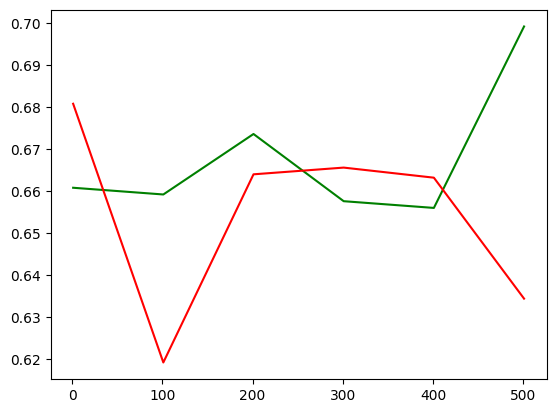

In [83]:
import matplotlib.pyplot as plt
import numpy as np

simulador_data = read_from_file("resultset_1")
qpu_data = read_from_file("resultset_2")

plt.plot(*zip(*simulador_data),'g', *zip(*qpu_data), 'r')

plt.show()